In [53]:
import numpy as np
from scipy.stats import binom, nbinom, poisson, hypergeom

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'  # Para gráficos de alta resolución
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['figure.dpi'] = 120
plt.rcParams['legend.fontsize'] = "small"
plt.rcParams['axes.labelsize'] = 'large'

rng = np.random.default_rng(42)  # La respuesta a la pregunta de la vida, el universo y todo lo demás

## 1.
En Python puede usarse la función `random(n)` de numpy para generar `n` números aleatorios en el intervalo $[0, 1)$ distribuidos uniformemente. Así, para mostar que la probabilidad de obtener un número en el intervalo $[0, p)$ es $p$, puede observarse en una muestra suficientemente grande que aproximadamente $p \cdot n$ de ellos pertenezcan a dicho intervalo (es decir, una fracción $\sim p$ de la muestra pertenece al intervalo). Así, una posible demostración computacional de esta propiedad podría consistir del siguiente experimento:
* Generar $n$ números aleatorios en el intervalo $[0, 1)$ mediante la función `random`.
* Para distintos valores de $p$, contar qué fracción ($f_\mathrm{obs}$) de los $n$ valores generados pertenece al intervalo $[0, p)$ (equivalentemente, la fracción de los valores que es menor a $p$).
* Verificar que la diferencia entre $f_\mathrm{obs}$ y $p$ disminuye para todo $p$ a medida que $n$ aumenta.

Si bien queda demostrado por ser el caso complementario, el mismo experimento puede realizarse para mostrar que la probalidad de que el número pertenezca al intervalo $[p, 1)$ es de $1 - p$.

In [76]:
# Cálculo de las fracciones de valores aleatorios menores que p para distintos tamaños de muestra
size_vals = np.geomspace(10, 1e6, 25, dtype=int)  # 10, 16, 26, ..., 1_000_000
prob_vals = np.linspace(0, 1, 101)  # 0, 0.01, 0.02, ..., 0.99, 1
frac_vals = np.empty((size_vals.size, prob_vals.size))  # Tantas filas como tamaños y tantas columnas como probabilidades
for i, sample_size in enumerate(size_vals):
    random_vals = rng.random(sample_size)
    for j, p in enumerate(prob_vals):
        frac_vals[i, j] = sum(random_vals < p) / sample_size

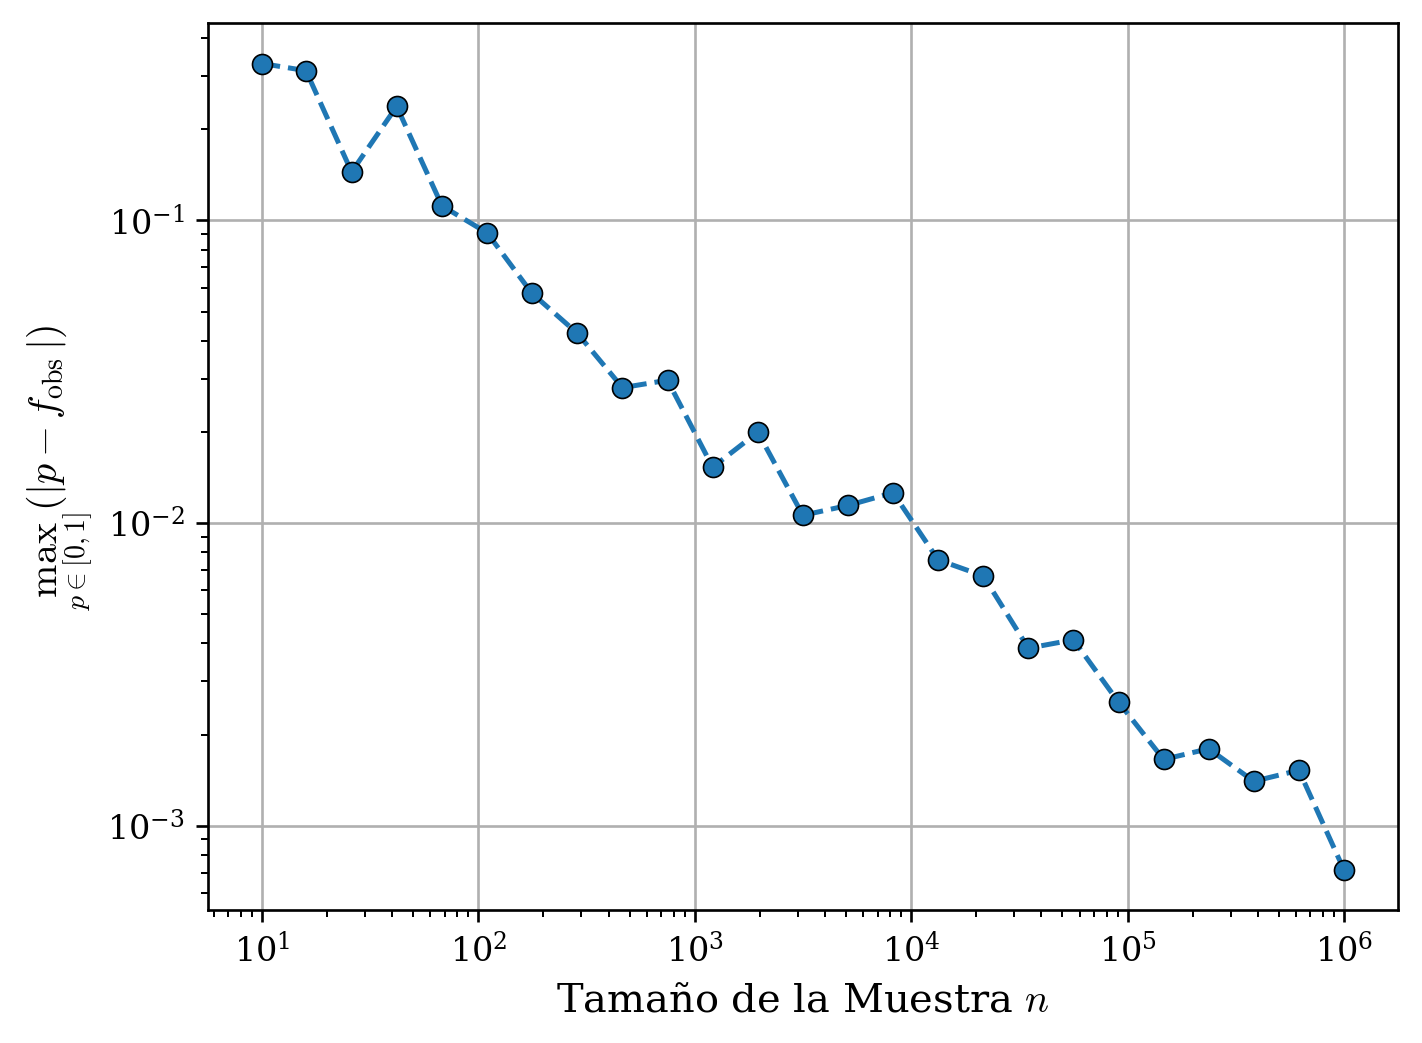

In [81]:
# Máxima diferencia absoluta entre p y f_obs para cada tamaño de muestra
fig, ax = plt.subplots(1, 1)
abs_dif_vals = np.abs(prob_vals - frac_vals)
ax.plot(size_vals, abs_dif_vals.max(axis=1), "o--", mec="k", mew=0.5)
ax.grid()
ax.set_xlabel("Tamaño de la Muestra $n$")
ax.set_ylabel(r"$\max_{p\in[0, 1]}(|p - f_\mathrm{obs}|)$")
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()

De la Figura anterior se puede notar que a medida que aumenta el tamaño de la muestra, el valor absoluto de la diferencia entre $p$ y la frecuencia observada disminuye para todos los valores de $p$ (ya que se observa que el máximo valor de esta diferencia se achica).

In [83]:
def simular_experimentos_bernoulli(n: int, p: float) -> int:
    """Simula `n` experimentos de Bernoulli con probabilidad de éxito `p` \
y devuelve el número de éxitos.
    """
    global rng
    resultados = rng.random(n) < p
    return resultados.sum()